In [2]:
from Classifier.load_data import read_arduino, process_data, read_arduinbro, load_training_data
from Classifier.classifier import classify_event, zeroes_classifier, one_pronged_smoothing_classifier, streaming_classifier

from copy import deepcopy
# from Levenshtein import distance as levenshtein_distance
from scipy import signal
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.io import wavfile

In [95]:
b = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(b.shape)
bt = np.apply_along_axis(np.mean, -1, b)
print(bt.shape)



(3, 3)
(3,)


In [222]:
"""
from numba import njit

@njit
"""
def get_event_regions(wav_array, samprate, labels_dat, before_buffer = 0.7,
                       after_buffer = 1):
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    event_bool = left_events_bool | right_events_bool
    return event_bool

#@njit


def get_test_stats(wav_array, window_size, step, test_stat_fns):
    test_stats = np.zeros((len(test_stat_fns), len(wav_array)))
        
    all_windows = sliding_window_view(wav_array, window_shape = window_size)

    all_windows = all_windows[::step, :]
    
    for i, fn in enumerate(test_stat_fns):
        testicles = np.apply_along_axis(fn, -1, all_windows)
        for j, teste in enumerate(testicles):
            if j == len(testicles)-1:
                test_stats[i, (j*step)::]  = teste
            else:
                test_stats[i, (j*step):((j+1)*step)]  = teste
    return test_stats
        
        

def contrast_all_files(window_size, 
                       test_stat_fns,
                       samprate,     
                       waves,        
                       labels,       
                       contrast_fn,
                       step=0.1):   
    
    step = int(step*samprate)
    start = time.time()
    
    for i, key in enumerate(waves.keys()):
        wav_array = waves[key]
        labels_dat = labels[key]
        
        total_time = len(wav_array)/samprate
        
        if i == 0:
            events_bool = get_event_regions(wav_array, samprate, labels_dat)
        else:
            events_bool = np.concatenate((events_bool, get_event_regions(wav_array, samprate, labels_dat)), axis = 0)
        
        if i == 0:
            test_stats = get_test_stats(wav_array, window_size, step, test_stat_fns)
            test_stats0 = test_stats
        else:
            test_stats0 = get_test_stats(wav_array, window_size, step, test_stat_fns)
            test_stats = np.concatenate(
                (test_stats, test_stats0),
                axis=1)
            

         
    event_test_stats = test_stats[:, events_bool]           
    non_event_test_stats = test_stats[:, ~events_bool]
    

    if len(event_test_stats) > 0 and len(non_event_test_stats) > 0:
        contrast_stat = contrast_fn(event_test_stats, non_event_test_stats)
        print(contrast_stat)
        end = time.time()
        print("time taken: ", end - start)
        return contrast_stat
    else:
        end = time.time()
        print("time taken: ", end - start)
        print("len 0!!!!")

In [232]:
waves, labels, samprate = load_training_data(path = "Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow"])
"""
labels1 = np.array([])
waves1 = []
i = 0
for key in waves.keys():
    waves1.append(list(waves[key]))
print(type(waves1))
print(type(waves1[1]))
print(type(waves1[1][1]))
waves1 = np.ndarray(waves1, np.float64)
print(waves1[1])
print(len(waves1))
print(len(waves1[5]))
"""

tfn_candidates = {"Range": lambda x: np.max(x) - np.min(x),
             "IQR": lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25),
             "SD": np.std,
             "Absolute Max": lambda x: np.max(np.abs(x)),
             "Zero Crossings": lambda x: np.sum(x[0:-1]*x[1::] <= 0)}


def contrast(x, y): 
    pooled_sd = np.sqrt(np.var(x)/len(x) + np.var(y)/len(y))
    return (np.mean(x, axis=1) - np.mean(y, axis=1))/pooled_sd


contrasts = []
for x in np.linspace(1, 20000, 10):
    x = int(x)
    print(x)
    contrasts.append(
        contrast_all_files(window_size = x, 
                           test_stat_fns = tfn_candidates.values(),
                           samprate = samprate,
                           waves = waves,
                           labels = labels,
                           step = 0.1,
                           contrast_fn = contrast
                           )
    )


/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Classifier/load_data.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


dict_keys(['left-right-middle-sandeep', 'left-right-middle-marina', 'left-middle-right-middle', 'left-middle', 'left-right-middle-marina3', 'left-middle-right-steph', 'left-right-middle-marina2', 'right-middle', 'left-middle-right-steph2', 'left-middle-right-middle#2']) dict_keys(['left-right-middle-sandeep', 'left-right-middle-marina', 'left-middle-right-middle', 'left-middle', 'left-right-middle-marina3', 'left-middle-right-steph', 'left-right-middle-marina2', 'right-middle', 'left-middle-right-steph2', 'left-middle-right-middle#2'])
[0.         0.         0.         2.13550001 0.        ]
time taken:  3.437351942062378
[ 1.76391472  0.88651943  0.56668885  1.67452377 -0.68206919]
time taken:  3.4785890579223633
[ 2.42617771  0.71548449  0.67232747  1.85604145 -1.08960259]
time taken:  3.525912046432495
[ 2.67940161  0.65980411  0.65472973  1.86727031 -1.41118023]
time taken:  3.657118320465088
[ 2.38797247  0.58576747  0.52523105  1.52767121 -1.54809852]
time taken:  3.8122298717498

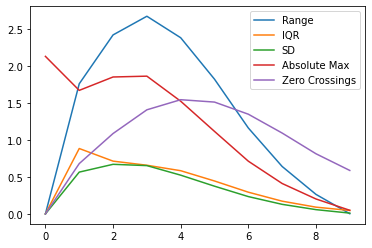

In [233]:
# plt.plot(contrasts[:, 0])

contrasts = np.abs(np.array(contrasts))

fig, ax = plt.subplots(1, 1)

for i, teststat in enumerate(tfn_candidates.keys()):
    ax.plot(contrasts[:, i], label = teststat)

ax.legend()
